Downloading...
From: https://drive.google.com/uc?id=15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_
To: /content/True.csv
100%|██████████| 53.6M/53.6M [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r
To: /content/Fake.csv
100%|██████████| 62.8M/62.8M [00:00<00:00, 188MB/s]


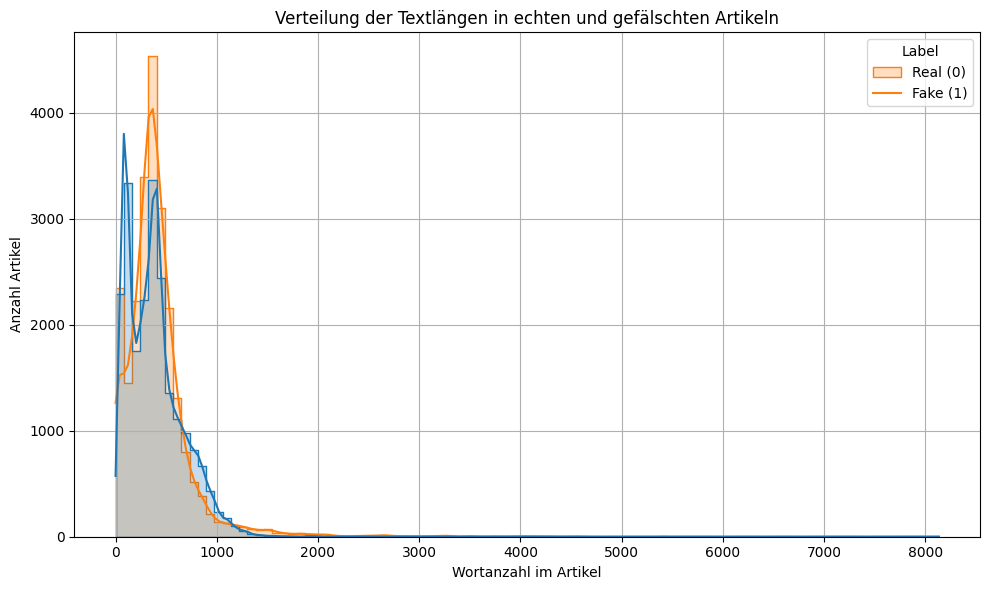

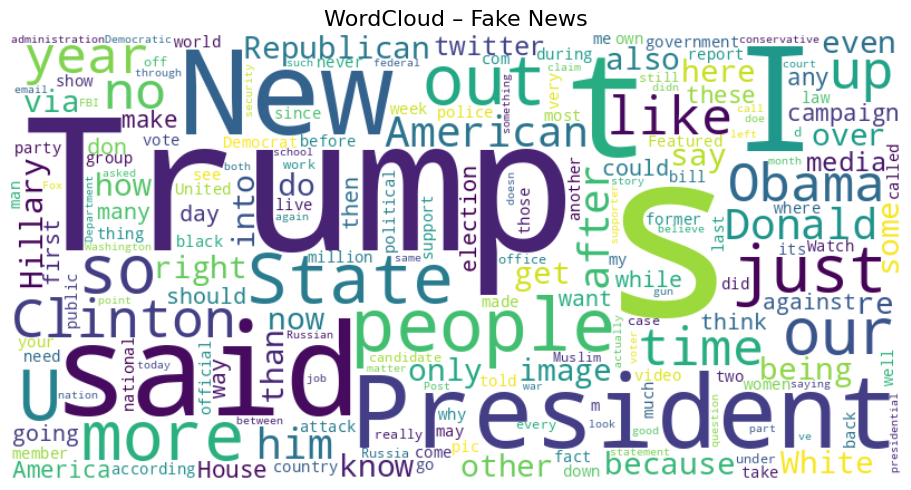

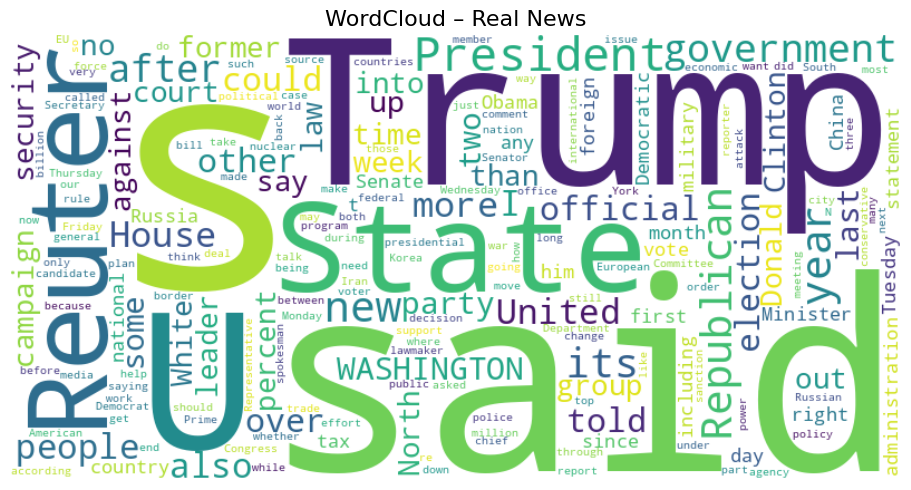

🔎 Accuracy: 0.9973273942093541

📊 Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4330
        Fake       1.00      1.00      1.00      4650

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

🧩 Confusion Matrix:
 [[4323    7]
 [  17 4633]]


In [2]:
# 📦 Pakete importieren
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 📥 CSV-Dateien von Google Drive via gdown herunterladen
!pip install -q gdown
import gdown

# Datei-IDs aus Google Drive
true_file_id = "15C_WRtKOjRhKVbZDvqj5o-XQAw4YAwX_"
fake_file_id = "19NNkzWwreIsIAmWePIk4XxQtiVG2jq9r"

# Herunterladen der CSV-Dateien
gdown.download(f"https://drive.google.com/uc?id={true_file_id}", "True.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={fake_file_id}", "Fake.csv", quiet=False)

# ▶️ CSVs laden & labeln
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")
true_df["label"] = 0
fake_df["label"] = 1

# 🔧 Alternative Stopword-Liste (offline verwendbar)
basic_stopwords = {
    "the", "and", "to", "of", "a", "in", "that", "is", "for", "on", "with",
    "as", "was", "at", "by", "an", "be", "this", "have", "from", "or", "it",
    "are", "not", "has", "but", "had", "they", "you", "he", "she", "we", "will",
    "their", "his", "her", "about", "would", "there", "what", "when", "which",
    "who", "were", "can", "them", "all", "been", "one", "if"
}

# 🧾 Zusammenführen
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

# 📊 Explorative Datenanalyse
combined_df["text_length"] = combined_df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="text_length", hue="label", bins=100, kde=True, element="step")
plt.title("Verteilung der Textlängen in echten und gefälschten Artikeln")
plt.xlabel("Wortanzahl im Artikel")
plt.ylabel("Anzahl Artikel")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

# WordCloud-Funktion
def create_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color="white",
                   stopwords=basic_stopwords, collocations=False).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# WordClouds erzeugen
create_wordcloud(" ".join(combined_df[combined_df["label"] == 1]["text"].dropna()), "WordCloud – Fake News")
create_wordcloud(" ".join(combined_df[combined_df["label"] == 0]["text"].dropna()), "WordCloud – Real News")

# 🤖 Machine Learning: Klassifikation
X = combined_df["text"].astype(str)
y = combined_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_pred = rf_model.predict(X_test_tfidf)

# 📈 Ergebnisse
print("🔎 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
print("🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



📈 Deskriptive Statistik:
          word_count  num_exclamations   upper_ratio
count  38564.000000      38564.000000  38564.000000
mean     398.060938          0.369645      0.043113
std      309.454430          1.424916      0.031943
min        1.000000          0.000000      0.007538
25%      214.000000          0.000000      0.030612
50%      364.000000          0.000000      0.037283
75%      505.000000          0.000000      0.047346
max     8044.000000        133.000000      0.882353

🔗 Korrelationen:
                      label  word_count  num_exclamations  upper_ratio
label             1.000000    0.069518          0.238285     0.047404
word_count        0.069518    1.000000          0.073968    -0.209599
num_exclamations  0.238285    0.073968          1.000000     0.113324
upper_ratio       0.047404   -0.209599          0.113324     1.000000


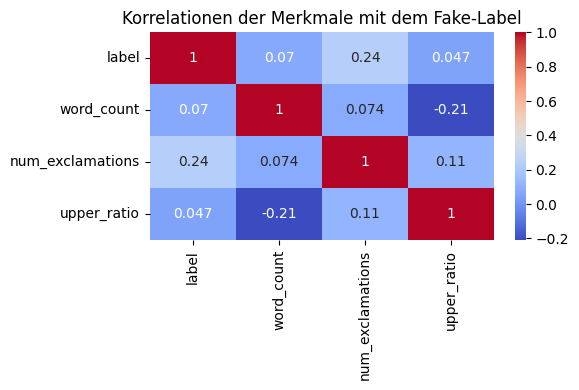

In [3]:
import re
import numpy as np

# 🔧 Text-Bereinigung: Funktion definieren
def clean_text(text):
    text = str(text).lower()  # alles klein
    text = re.sub(r"http\S+", "", text)  # URLs entfernen
    text = re.sub(r"[^a-z\s]", "", text)  # Sonderzeichen entfernen
    text = re.sub(r"\s+", " ", text).strip()  # Extra-Leerzeichen entfernen
    return text

# Bereinigen der Textspalte
combined_df["clean_text"] = combined_df["text"].apply(clean_text)

# Entferne leere Texte oder Nullwerte
combined_df.dropna(subset=["clean_text"], inplace=True)
combined_df = combined_df[combined_df["clean_text"].str.strip() != ""]

# Entferne Duplikate (z. B. doppelte Artikel)
combined_df.drop_duplicates(subset=["clean_text"], inplace=True)

# Neue Features: Satzzeichen, Großbuchstabenanteil, Wortanzahl
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: str(x).count("!"))
combined_df["upper_ratio"] = combined_df["text"].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))

# 🧮 Statistische Kennzahlen & Korrelation
print("\n📈 Deskriptive Statistik:\n", combined_df[["word_count", "num_exclamations", "upper_ratio"]].describe())

# Korrelation dieser Features mit Fake/Real
correlation = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].corr()
print("\n🔗 Korrelationen:\n", correlation)

# Visualisierung der Korrelationen
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Korrelationen der Merkmale mit dem Fake-Label")
plt.tight_layout()
plt.show()


In [4]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

# VADER initialisieren
sia = SentimentIntensityAnalyzer()

# Sentiment Scores berechnen (compound reicht oft aus)
combined_df["sentiment"] = combined_df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


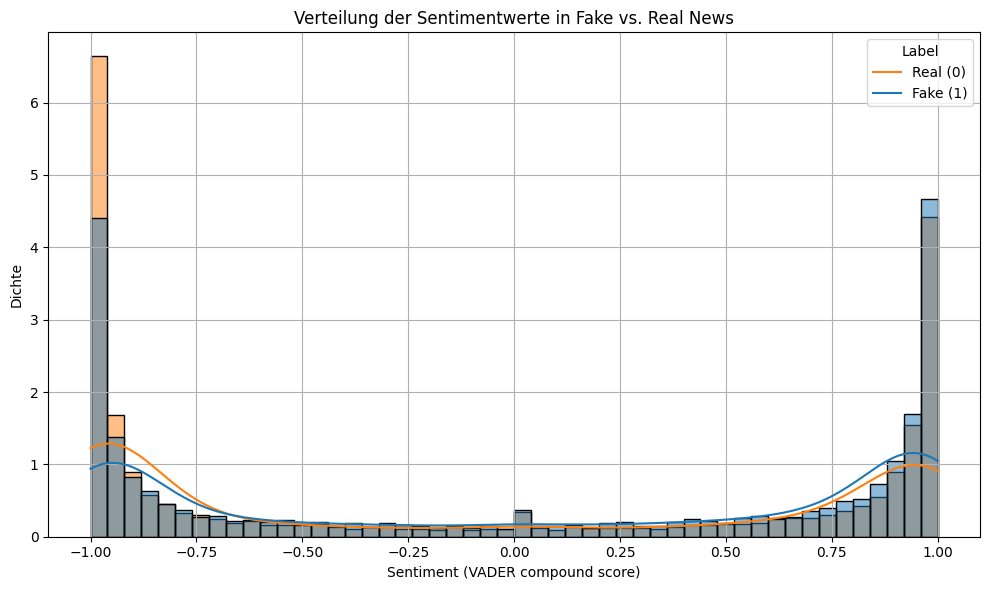

In [5]:
# Verteilung der Sentimentwerte
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="sentiment", hue="label", bins=50, kde=True, stat="density", common_norm=False)
plt.title("Verteilung der Sentimentwerte in Fake vs. Real News")
plt.xlabel("Sentiment (VADER compound score)")
plt.ylabel("Dichte")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()


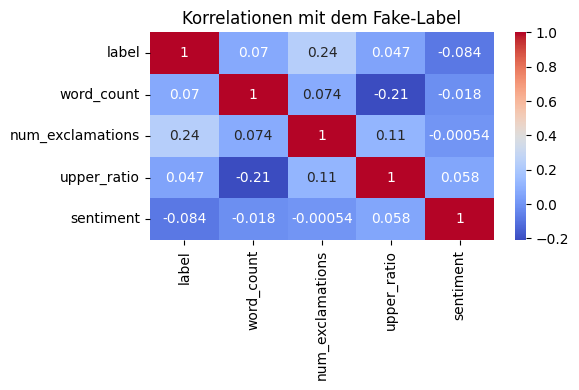

📌 Ausgewählte Features für Modellierung: ['num_exclamations']


In [6]:
# Neue Feature-Tabelle mit potenziellen Predictors
feature_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio", "sentiment"]]

# Korrelationen
corr_matrix = feature_df.corr()

# Visualisierung
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korrelationen mit dem Fake-Label")
plt.tight_layout()
plt.show()

# Optional: Nur stärkere Korrelationen wählen (z. B. |r| > 0.1)
correlated_features = corr_matrix["label"].drop("label").abs()
selected_features = correlated_features[correlated_features > 0.1].index.tolist()

print("📌 Ausgewählte Features für Modellierung:", selected_features)


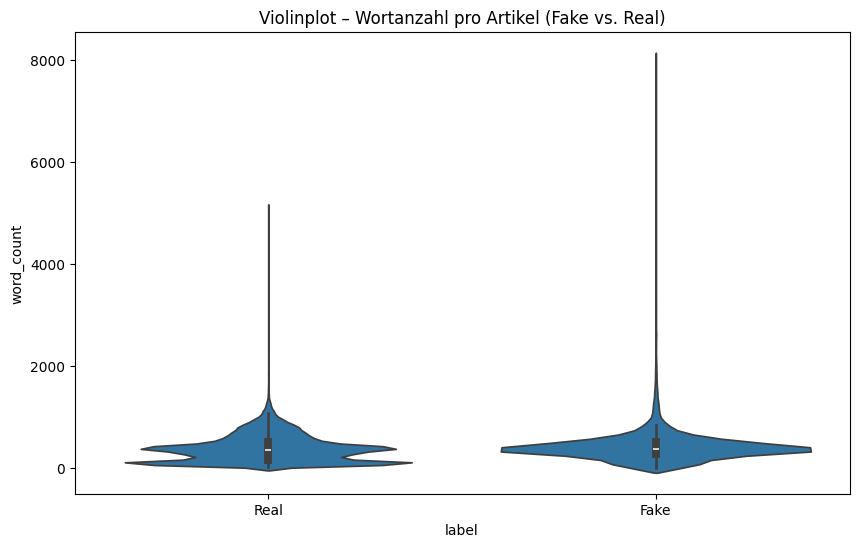

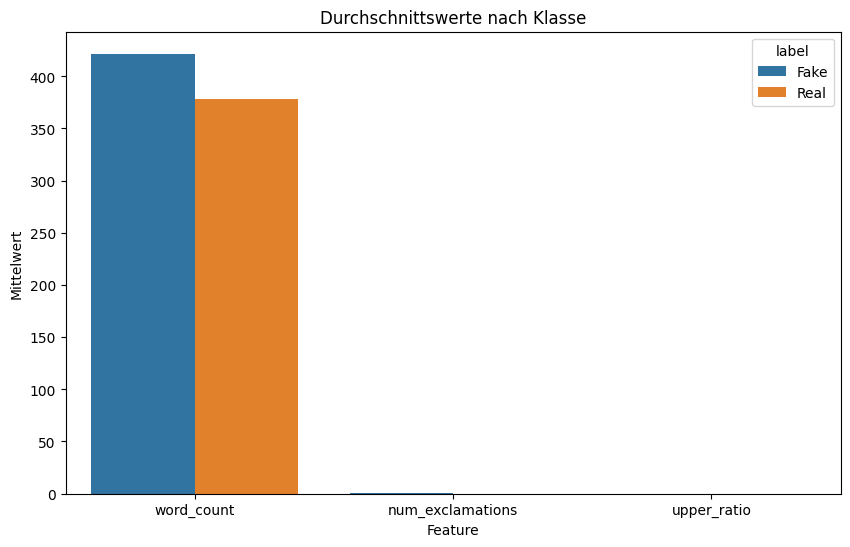

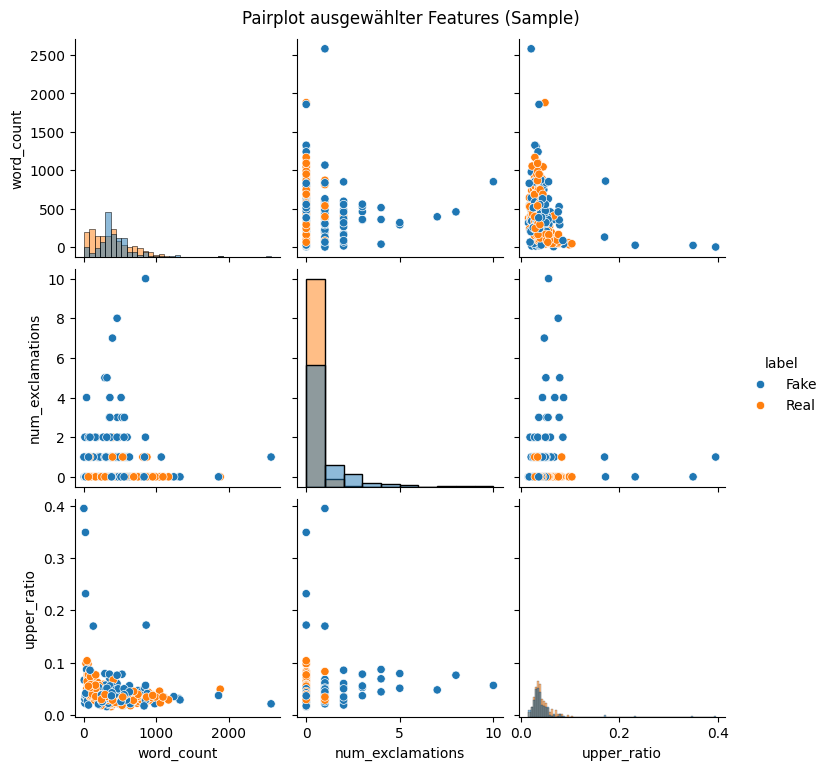

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features berechnen
combined_df["word_count"] = combined_df["clean_text"].apply(lambda x: len(x.split()))
combined_df["num_exclamations"] = combined_df["text"].apply(lambda x: x.count("!"))
combined_df["upper_ratio"] = combined_df["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Plot-Daten vorbereiten
plot_df = combined_df[["label", "word_count", "num_exclamations", "upper_ratio"]].copy()
plot_df["label"] = plot_df["label"].map({0: "Real", 1: "Fake"})

# 🎻 Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x="label", y="word_count", data=plot_df)
plt.title("Violinplot – Wortanzahl pro Artikel (Fake vs. Real)")
plt.savefig("violinplot_wordcount.png")
plt.show()

# 📊 Balkendiagramm: Mittelwerte je Klasse
mean_values = plot_df.groupby("label")[["word_count", "num_exclamations", "upper_ratio"]].mean().reset_index()
mean_values = mean_values.melt(id_vars="label", var_name="Feature", value_name="Mittelwert")

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_values, x="Feature", y="Mittelwert", hue="label")
plt.title("Durchschnittswerte nach Klasse")
plt.savefig("grouped_barplot_features.png")
plt.show()

# 🔁 Pairplot (kleines Sample)
pairplot_data = plot_df[["word_count", "num_exclamations", "upper_ratio", "label"]].sample(500)
sns.pairplot(data=pairplot_data, hue="label", diag_kind="hist")
plt.suptitle("Pairplot ausgewählter Features (Sample)", y=1.02)
plt.savefig("pairplot_sample500.png")
plt.show()


In [8]:
!pip install transformers datasets scikit-learn --quiet
!pip install shap lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==1

In [9]:
from transformers import pipeline
from sklearn.metrics import classification_report

# Pipeline laden: Textklassifikation (binary)
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

# Beispieldaten – kleiner Test aus eurem Datensatz
sample_df = combined_df.sample(100)
texts = sample_df["clean_text"].tolist()

# Modellvorhersagen
predictions = classifier(texts, truncation=True)

# Zuordnung: "LABEL_1" = positive (realistisch), "LABEL_0" = negative (fake)
sample_df["bert_pred"] = [1 if p["label"] == "LABEL_1" else 0 for p in predictions]

# Vergleich mit echten Labels
print(classification_report(sample_df["label"], sample_df["bert_pred"], target_names=["Real", "Fake"]))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


              precision    recall  f1-score   support

        Real       0.56      1.00      0.72        56
        Fake       0.00      0.00      0.00        44

    accuracy                           0.56       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.31      0.56      0.40       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# ----- Spalten aufteilen -----
text_col   = "clean_text"
num_cols   = selected_features            # z.B. ['word_count', 'upper_ratio', 'sentiment', …]

tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1,2), stop_words="english")

preproc = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("num",  StandardScaler(), num_cols)
    ])

# ----- Modelle definieren -----
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
svm    = LinearSVC(class_weight='balanced')      # braucht Kalibrierung für Prob‑Ausgabe

pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm    = Pipeline([("prep", preproc), ("clf", CalibratedClassifierCV(svm, cv=3))])

# ----- GridSearch -----
param_grid = {
    "clf__C": [0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_logreg, param_grid, cv=cv,
                    scoring="roc_auc", n_jobs=-1, verbose=2)

grid.fit(combined_df[[text_col] + num_cols], combined_df["label"])

print("Beste Parameter:", grid.best_params_)
print("ROC‑AUC (CV):", grid.best_score_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Beste Parameter: {'clf__C': 10}
ROC‑AUC (CV): 0.9995527308884391


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Beste Parameter: {'clf__C': 10}
ROC‑AUC (CV): 0.9994769035499935

Test‑ROC‑AUC: 0.9995174502036173
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      4234
        Fake       0.99      0.99      0.99      3479

    accuracy                           0.99      7713
   macro avg       0.99      0.99      0.99      7713
weighted avg       0.99      0.99      0.99      7713



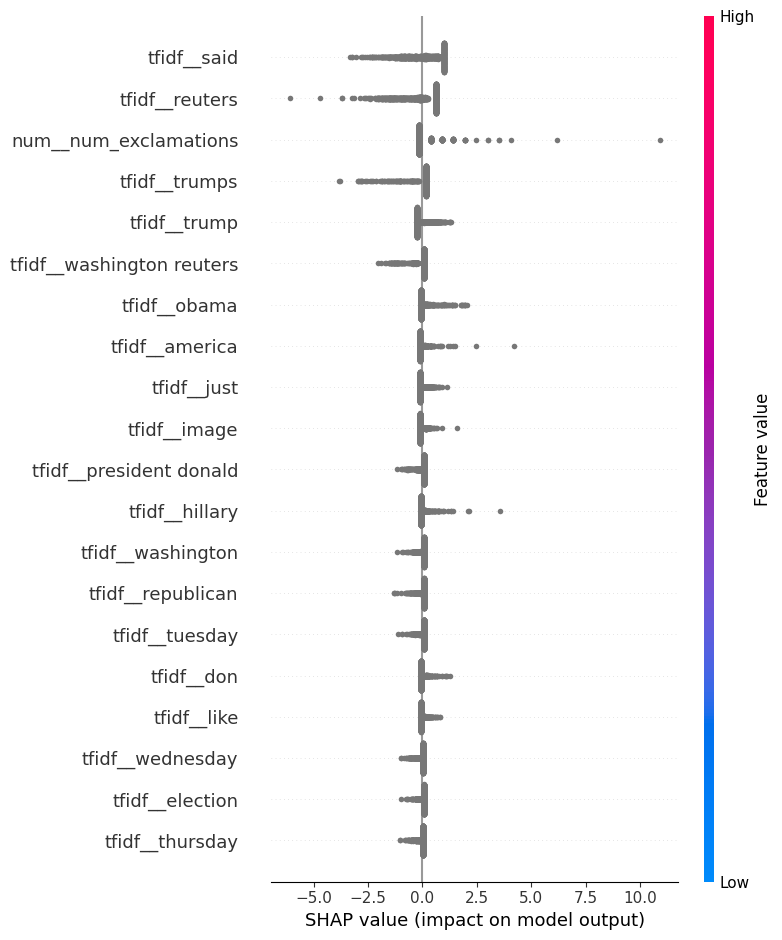

In [11]:
# ======================================================
# 1 ▸ FEATURE‑SET & TRAIN‑TEST‑SPLIT
# ======================================================
from sklearn.model_selection import train_test_split

text_col    = "clean_text"
num_cols    = selected_features          # z.B. ['word_count', 'upper_ratio', ...]

feature_cols = [text_col] + num_cols     # genau diese Spalten erwartet der ColumnTransformer

X = combined_df[feature_cols].copy()     # DataFrame – keine Series!
y = combined_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ======================================================
# 2 ▸ PIPELINE, GRID‑SEARCH & BESTES MODELL
# ======================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

tfidf = TfidfVectorizer(max_features=10_000,
                        ngram_range=(1,2),
                        stop_words="english")

preproc = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("num",   StandardScaler(), num_cols)
    ])

logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
svm    = LinearSVC(class_weight='balanced')

pipe_logreg = Pipeline([("prep", preproc), ("clf", logreg)])
pipe_svm    = Pipeline([("prep", preproc),
                        ("clf", CalibratedClassifierCV(svm, cv=3))])  # falls du SVM testen willst

param_grid = {"clf__C": [0.1, 1, 10]}
cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_logreg,
                    param_grid,
                    cv=cv,
                    scoring="roc_auc",
                    n_jobs=-1,
                    verbose=2)

grid.fit(X_train, y_train)

print("Beste Parameter:", grid.best_params_)
print("ROC‑AUC (CV):",   grid.best_score_)
best_model = grid.best_estimator_

# ======================================================
# 3 ▸ TEST‑SET‑EVALUATION
# ======================================================
from sklearn.metrics import classification_report, roc_auc_score

y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred       = (y_pred_proba >= 0.5).astype(int)

print("\nTest‑ROC‑AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))

# ======================================================
# 4 ▸ SHAP‑ERKLÄRBARKEIT (GLOBAL)
# ======================================================
import shap, numpy as np
shap.initjs()

#  ≤ 800 Samples für Geschwindigkeit
sample_size = min(800, len(X_test))
X_sample    = X_test.sample(sample_size, random_state=0)

prep           = best_model.named_steps["prep"]
clf            = best_model.named_steps["clf"]

X_enc          = prep.transform(X_sample)                # sparse/dense Matrix (TF‑IDF + numerisch)
feature_names  = prep.get_feature_names_out()            # automatische Namen aller Features

explainer      = shap.Explainer(clf, X_enc,
                                feature_names=feature_names)
shap_values    = explainer(X_enc)

shap.summary_plot(shap_values, X_enc,
                  feature_names=feature_names,
                  max_display=20)        # globale Wichtigkeit


In [12]:
# ======================================================
# 7 ▸ RANDOM FOREST als zweites Modell
# ======================================================
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42)

pipe_rf = Pipeline([("prep", preproc), ("clf", rf)])

rf_auc = cross_val_score(pipe_rf, X, y, cv=cv,
                         scoring="roc_auc",
                         n_jobs=-1).mean()
print(f"Random Forest 5‑fold ROC‑AUC: {rf_auc:0.4f}")

# ▸ Train auf gesamten Trainingssplit, um später SHAP TreeExplainer zu nutzen
pipe_rf.fit(X_train, y_train)


Random Forest 5‑fold ROC‑AUC: 0.9998


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

In [13]:
# ======================================================
#  Prob‑kalibrierter Linear SVM (falls gewünscht) 7B
# ======================================================
from sklearn.calibration import CalibratedClassifierCV

svm    = LinearSVC(class_weight="balanced")
pipe_svm = Pipeline([("prep", preproc),
                     ("clf",  CalibratedClassifierCV(svm, cv=3))])

svm_auc = cross_val_score(pipe_svm, X, y, cv=cv,
                          scoring="roc_auc",
                          n_jobs=-1).mean()
print(f"Calibrated SVM 5‑fold ROC‑AUC: {svm_auc:0.4f}")
pipe_svm.fit(X_train, y_train)


Calibrated SVM 5‑fold ROC‑AUC: 0.9995


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'clean_text'),
                                                 ('num', StandardScaler(),
                                                  ['num_exclamations'])])),
                ('clf',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LinearSVC(class_weight='balanced')))])

In [14]:
from sklearn.metrics import precision_recall_curve, f1_score

proba_val = best_model.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, proba_val)
f1   = 2*prec*rec/(prec+rec+1e-8)
best_thr = thr[f1.argmax()]

print(f"Optimaler Cut‑off für F1: {best_thr:0.3f}")
y_pred_opt = (proba_val >= best_thr).astype(int)
print("F1 @opt:", f1_score(y_test, y_pred_opt))

# Regressions‑Output (Wahrscheinlichkeit) kann direkt als ŷ genutzt werden
# z.B. für Ranking oder als KPI im Dashboard. 7 C


Optimaler Cut‑off für F1: 0.390
F1 @opt: 0.9919724770642202


In [15]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

combined_df["clean_text"] = combined_df["text"].apply(clean_text)


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# 🧾 Vorverarbeitung definieren
text_col = "clean_text"
num_cols = []  # falls numerische Features vorhanden sind (z. B. word_count), hier einfügen

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
preproc = ColumnTransformer([("tfidf", tfidf, text_col)])

# 📦 Modelle definieren
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3)
}

# 🔀 Split vorbereiten
X = combined_df[[text_col]]
y = combined_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 📊 Ergebnisse sammeln
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preproc),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Falls möglich: ROC-AUC mit predict_proba oder decision_function
    try:
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
        else:
            y_proba = pipe.decision_function(X_test)
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None

    results.append({
        "Modell": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc
    })

# 📋 Als Tabelle anzeigen
results_df = pd.DataFrame(results)
print("\n📊 Modellvergleich:\n")
display(results_df.sort_values("F1-Score", ascending=False))


📊 Modellvergleich:



,Modell,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.996888,0.997122,0.995976,0.996549,0.999869
2,SVM,0.992351,0.992512,0.990515,0.991512,0.999400
1,Logistic Regression,0.985738,0.988686,0.979592,0.984118,0.998576
